In [1]:
import psycopg2
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import configparser
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
def fetch_data():
    config = configparser.ConfigParser()
    config.read('db_config.ini')

    host = config['database']['host']
    port = config['database'].getint('port')
    user = config['database']['user']
    password = config['database']['password']
    database = config['database']['database']

    connection = psycopg2.connect(
        host=host,
        port=port,
        user=user,
        password=password,
        database=database
    )

    df1 = pd.read_sql('SELECT * FROM turbofan_engine_data', con=connection)
    df2 = pd.read_sql('SELECT * FROM turbofan_rul_data', con=connection)

    connection.close()

    return df1, df2

In [3]:
df1, df2 = fetch_data()

In [4]:
def clean_data(df):
    # Handling missing values
    na_counts_before = df.isna().sum()
    if na_counts_before.sum() > 0:
        print(f"Rows with missing values before: {na_counts_before.sum()}")
        df = df.dropna(axis=0)
        na_counts_after = df.isna().sum()
        print(f"Rows with missing values after: {na_counts_after.sum()}")
    else:
        print("No missing values found. Proceeding with the original DataFrame.")

    # Handling duplicates
    duplicates_before = df[df.duplicated(keep='first')]
    if len(duplicates_before) > 0:
        print(f"Duplicates before: {len(duplicates_before)}")
        df = df.drop_duplicates(keep='first')
        duplicates_after = df[df.duplicated(keep='first')]
        print(f"Duplicates after: {len(duplicates_after)}")
    else:
        print("No duplicate rows found. Proceeding with the original DataFrame.")

    return df

In [5]:
df1 = clean_data(df1)
df2 = clean_data(df2)

No missing values found. Proceeding with the original DataFrame.
No duplicate rows found. Proceeding with the original DataFrame.
No missing values found. Proceeding with the original DataFrame.
No duplicate rows found. Proceeding with the original DataFrame.


In [6]:
train_df = df1[df1["source"] == 0].copy()
test_df = df1[df1["source"] == 1].copy()

# **DERIVING RUL COLUMN**

In [7]:
def add_rul_train(df):
    max_cycles_train = df.groupby('engine')['cycle'].max().reset_index()
    max_cycles_train.columns = ['engine', 'max_cycle_train']
    df = df.merge(max_cycles_train, on='engine', how='left')
    df['RUL'] = df['max_cycle_train'] - df['cycle']
    df.drop(['max_cycle_train'], axis=1, inplace=True)
    return df

In [8]:
def add_rul_test(df, external_rul_df):
    df = df.merge(external_rul_df[['engine', 'RUL']], on='engine', how='left')
    return df

In [9]:
train_df_with_rul = add_rul_train(train_df)
test_df_with_rul = add_rul_test(test_df, df2)

In [10]:
relevant_cols = ['LPC_outlet_temperature (T24)', 'HPC_outlet_temperature (T30)',
                 'LPT_outlet_temperature (T50)', 'fan_inlet_pressure (P2)',
                 'bypass_duct_pressure (P15)', 'fan_speed (Nf)', 'core_speed (Nc)',
                 'HPC_outlet_static_pressure (Ps30)', 'altitude (alt)', 'mach_number (mach)',
                 'throttle_resolver_angle (TRA)', 'fan_inlet_temperature (T2)',
                 'HPC_outlet_pressure (P30)', 'engine_pressure_ratio (epr)',
                 'fuel_ps30_ratio (phi)', 'corrected_fan_speed (NRf)', 'corrected_core_speed (NRc)',
                 'bypass_ratio (BPR)', 'burner_fuel_air_ratio (farB)', 'bleed_enthalpy (htBleed)',
                 'demanded_fan_speed (Nf_dmd)', 'demanded_corrected_fan_speed (PCNfR_dmd)',
                 'HPT_coolant_bleed (W31)', 'LPT_coolant_bleed (W32)']

In [11]:
X_train= train_df_with_rul[relevant_cols]
y_train= train_df_with_rul['RUL']

In [12]:
test_last_cycle = test_df_with_rul.groupby('engine')['cycle'].idxmax()
test_last_cycle_df = test_df_with_rul.loc[test_last_cycle]

X_test = test_last_cycle_df[relevant_cols]
y_test = test_last_cycle_df['RUL']

In [13]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    rmse = int(np.sqrt(mean_squared_error(y, y_pred)))
    mae = int(mean_absolute_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    return rmse, mae, round(r2, 4)

# **PCA**

In [15]:
pca = PCA().fit(X_train_scaled)

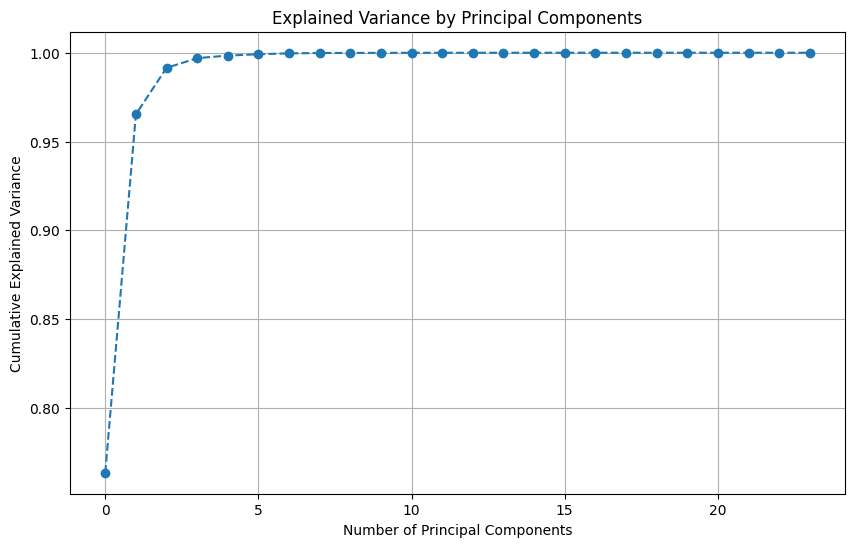

Number of components selected: 3


In [16]:
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# Selecting number of components to explain 99% of the variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.99) + 1
print(f'Number of components selected: {n_components}')

In [17]:
pca = PCA(n_components=n_components)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [18]:
model_lr = LinearRegression()
model_lr.fit(X_train_pca, y_train)

train_rmse, train_mae, train_r2 = evaluate_model(model_lr, X_train_pca, y_train)
print(f'Train RMSE: {train_rmse}, Train MAE: {train_mae}, Train R²: {train_r2}')

test_rmse, test_mae, test_r2 = evaluate_model(model_lr, X_test_pca, y_test)
print(f'Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test R²: {test_r2}')

Train RMSE: 68, Train MAE: 56, Train R²: 0.0078
Test RMSE: 59, Test MAE: 50, Test R²: -0.2208


In [19]:
model_svr = SVR()
model_svr.fit(X_train_pca, y_train)

train_rmse, train_mae, train_r2 = evaluate_model(model_svr, X_train_pca, y_train)
print(f'Train RMSE: {train_rmse}, Train MAE: {train_mae}, Train R²: {train_r2}')

test_rmse, test_mae, test_r2 = evaluate_model(model_svr, X_test_pca, y_test)
print(f'Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test R²: {test_r2}')

Train RMSE: 67, Train MAE: 54, Train R²: 0.0492
Test RMSE: 55, Test MAE: 46, Test R²: -0.0626


In [20]:
model_rf_selected = RandomForestRegressor(random_state=42)
model_rf_selected.fit(X_train_pca, y_train)

train_rmse_rf, train_mae_rf, train_r2_rf = evaluate_model(model_rf_selected, X_train_pca, y_train)
print(f'Train RMSE (RF): {train_rmse_rf}, Train MAE (RF): {train_mae_rf}, Train R² (RF): {train_r2_rf}')

test_rmse_rf, test_mae_rf, test_r2_rf = evaluate_model(model_rf_selected, X_test_pca, y_test)
print(f'Test RMSE (RF): {test_rmse_rf}, Test MAE (RF): {test_mae_rf}, Test R² (RF): {test_r2_rf}')

Train RMSE (RF): 18, Train MAE (RF): 13, Train R² (RF): 0.9312
Test RMSE (RF): 38, Test MAE (RF): 27, Test R² (RF): 0.4859


In [21]:
model_pca_xgb = XGBRegressor(random_state=42)
model_pca_xgb.fit(X_train_pca, y_train)

train_rmse, train_mae, train_r2 = evaluate_model(model_pca_xgb, X_train_pca, y_train)
print(f'Train RMSE (PCA): {train_rmse}, Train MAE (PCA): {train_mae}, Train R² (PCA): {train_r2}')

test_rmse, test_mae, test_r2 = evaluate_model(model_pca_xgb, X_test_pca, y_test)
print(f'Test RMSE (PCA): {test_rmse}, Test MAE (PCA): {test_mae}, Test R² (PCA): {test_r2}')

Train RMSE (PCA): 43, Train MAE (PCA): 32, Train R² (PCA): 0.6011
Test RMSE (PCA): 35, Test MAE (PCA): 26, Test R² (PCA): 0.5659
